# Exoplanets HW2
## Miles Currie and Steven Stetzler

In [1]:
using Pkg
# Pkg.add("PyPlot")
# Pkg.add("Statistics")
# Pkg.add("Printf")

In [2]:
using DelimitedFiles
using PyPlot;
using Statistics
using Printf
using Optim
using IterTools

In [3]:
function load_data(fl_path)
    data = readdlm(fl_path)
    return data
end;

In [4]:
# load data
data_fl = "./mystery_planet02.txt"
data = load_data(data_fl)

# unpack data
time, flux, flux_err = data[:, 1], data[:, 2], data[:, 3];

# Overlap Area of Two Circles

We compute the overlap area between two circles of radius $x$ and $r_p$ with their centers separated by distance $d$ per the Batman prescription.

In [5]:
function overlap_area(x, r_p, d)
    # using bat-formalism 
    # x = stellar radius
    # r_p = planet radius
    # d = separation of star and planet centers
        
    # We only care about absolute distance between star and planet (sign doesn't matter)
    d = abs(d)
    
    u = (d^2 + x^2 - r_p^2) / (2*d*x)
    v = (d^2 + r_p^2 - x^2) / (2*d*r_p)
    w = (-d + x + r_p) * (d + x - r_p) * (d - x + r_p) * (d + x + r_p)

    if d >= r_p + x
        area = 0
    elseif r_p - d < x < r_p + d
        area = x^2*acos(u) + r_p^2*acos(v) - 0.5*sqrt(w)
    elseif x <= r_p - d
        area = pi * x^2
    elseif x >= r_p + d
        area = pi * r_p^2
    
    end
    
    return area
end;

We compute the overlap between two circles of radius $x = 1$ and $r_p = 0.5$ as a function of distance $d$ between their centers. We see that this looks like an inverted transit!

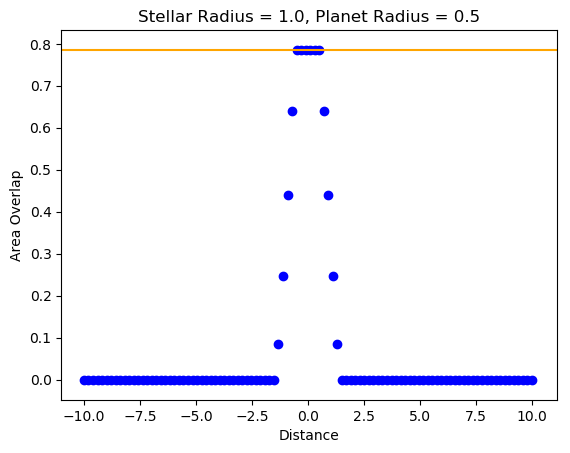

In [6]:
distances = range(-10, stop=10, length=100)
stellar_radius = 1
r_p = 0.5

for (t, d) in enumerate(distances)
    area = overlap_area(stellar_radius, r_p, d)
    scatter(d, area, c=:blue)
end
axhline(pi * r_p^2, color="orange")
xlabel("Distance")
ylabel("Area Overlap")
title(@sprintf("Stellar Radius = %0.1f, Planet Radius = %0.1f", stellar_radius, r_p))
show()

# Layer-Cake a la Batman (Batcake)

For a non-uniform intensity profile of the star, we need to integrate over the star to find the amount of flux blocked by the planet when transiting.
$$
\delta = \int\int I dA
$$
where $I$ is the intensity profile and is normalized to integrate to 1. For a radial intensity profile $I = I(r)$, we can compute this integral numerically using a single sum:
$$
\delta(d; r_p) = \sum_{i = 1}^n \Delta \delta_i(d; r_p)
$$
with
$$
\Delta \delta_i(d; r_p) = I \left( \frac{x_i + x_{i - 1}}{2} \right) \left[A(x_i, r_p, d) - A(x_{i - 1}, r_p, d)  \right]
$$

where $x$ is a grid of stellar radius values between $0$ and $1$. Here, we use a grid with uniform spacing of length 100. The function $\Delta \delta_i(d; r_p)$ is computed with the function `d_delta(i, x, d, r_p, I)`.

In [7]:
# Compute the quantity Delta delta
# I is the intensity profile
# A is the area of overlap function
# r_p is the radius of the planet
# d is the distance
function d_delta(i, x, d, r_p, I)
    avg_x = (x[i] + x[i - 1]) / 2
    delta_A = overlap_area(x[i], r_p, d) - overlap_area(x[i - 1], r_p, d)
    return I(avg_x) * delta_A
end;

## Intensity profile as a function of normalized stellar radius $x \in [0, 1] $

We find the normalization by integrating the intensity profile over the area of the circle:

$$
Z = \int_{0}^{1} \int_{0}^{2\pi} I(r) r dr d\theta = 2 \pi \int_{0}^{1} r I(r) dr.
$$

We have found these normalization factors for each of the three profiles below.

In [8]:
function I_const(x)
    Z = pi
    return  1 / Z
end;

In [9]:
function I_linear(x)
    Z = 2 * pi / 3
    I_0 = 1
    c_1 = 1
    mu = sqrt(1 - x^2)
    return I_0 * (1 - c_1*(1 - mu)) / Z
end;

In [10]:
function I_quadratic(x)
    Z = 3 * pi / 4
    I_0 = 1
    c_1 = 0.5
    c_2 = 0.5
    mu = sqrt(1 - x^2)
    return I_0 * (1 - c_1*(1 - mu) - c_2 * (1 - mu)^2) / Z
end;

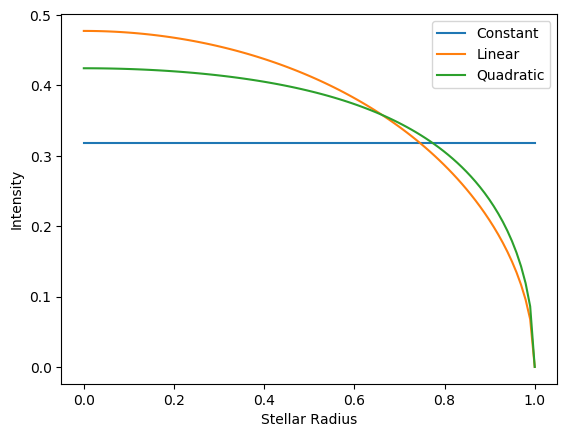

In [11]:
x_grid = range(0, stop=1, length=100)

plot(x_grid, I_const.(x_grid), label="Constant")
plot(x_grid, I_linear.(x_grid), label="Linear")
plot(x_grid, I_quadratic.(x_grid), label="Quadratic")
xlabel("Stellar Radius")
ylabel("Intensity")
legend()
show()

## Computation of delta at single d

Compute the sum 
$$
\delta(d; r_p) = \sum_{i = 1}^n \Delta \delta_i(d; r_p),
$$
as implemented in `compute_delta(d, planet_radius)`, where $I$, the intensity profile, is constant by default, and $x$ is a uniform grid over a 100 points by default.

In [12]:
function compute_delta(d, planet_radius; I_func=I_const, num_steps=100)
    x = collect(range(0, stop=1, length=num_steps))
    delta = 0
    for i in range(2, stop=num_steps)
        delta += d_delta(i, x, d, planet_radius, I_func)
    end
    return delta
end;

## The effects of limb-darkening on the transit shape

We show how limb-darkening changes the shape of the transit by plotting $\delta$ as a function of distance $d$ for a planetary radius of $R_p = 0.5 (R_{*})$ for the three different intensity profiles.

In theory, we can test any normalized intensity profile using this method.

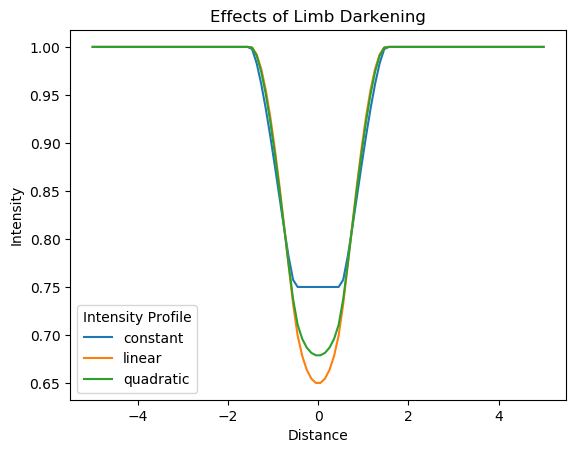

In [13]:
d_grid = collect(range(-5, stop=5, length=100))
deltas_const = []
deltas_linear = []
deltas_quatratic = []

r_p = 0.5

for d in d_grid
    append!(deltas_const, compute_delta(d, I_func=I_const, r_p))
    append!(deltas_linear, compute_delta(d, I_func=I_linear, r_p))
    append!(deltas_quatratic, compute_delta(d, I_func=I_quadratic, r_p)) 
end

figure()
title("Effects of Limb Darkening")
plot(d_grid, 1 .- deltas_const, label="constant")
plot(d_grid, 1 .- deltas_linear, label="linear")
plot(d_grid, 1 .- deltas_quatratic, label="quadratic")
legend(title="Intensity Profile")
xlabel("Distance")
ylabel("Intensity")
show()

# Period finding and transit fitting

Use **model** to fit the data. What is the 
- **Period**: $P$ from periodogram
- **depth**: From fitting transit curve ~ $(R_p / R_{*})^2$
- **impact parameter**: $b$ from fitting transit curve
- **duration**: $T$, from other parameters

# Raw Data

Plot the raw data: flux as a function of time.

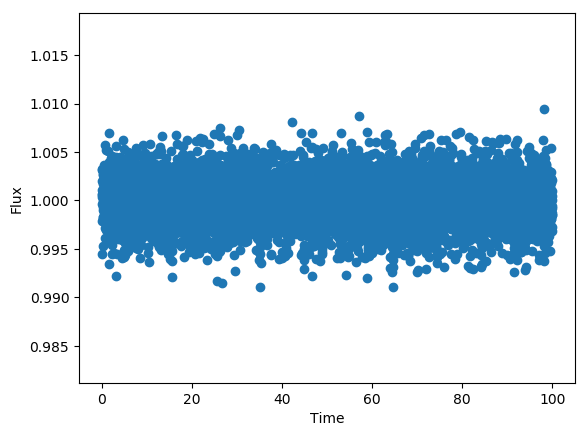

In [14]:
figure()
scatter(time, flux)
ylabel("Flux")
xlabel("Time")
show();

In [15]:
# For a given period, get the corresponding point in phase from a point in time
function get_phase(time, P)
    phase = (time ./ P) .% 1
    return phase
end;

Define the "scatter" between flux measurements $F$
$$
S_P = \sum_{i = 1}^{i = N - 1} (F_{i} - F_{i + 1})^2
$$

In [16]:
function compute_scatter(y)
    N = size(y)[1]
    scatter = 0
    for i in range(1, stop=N - 1)
        scatter = scatter + (y[i] - y[i + 1])^2
    end
    return scatter
end;

Compute a periodogram for a set of measurements $y$ as s function of time $t$ at each trial period value in $P_{vals}$

In [17]:
function periodogram(y, t, P_vals)
    scatters_list = []
    for period in P_vals
        phase = get_phase(t, period)
        phase_sorted_inds = sortperm(phase)
        y_phase_sorted = y[phase_sorted_inds]
        scatter = compute_scatter(y_phase_sorted)
        append!(scatters_list, scatter)
    end
    return scatters_list
end;

Plot data $y$ as a function of time folded on a given period.

In [18]:
function plot_folded_data(time, y, period)
    figure();
    phase = get_phase(time, period)
    scatter(phase, y)
    xlabel("Phase")
end;

## Smoothing function that averages over nearest neighbors (running average)

We want to smooth the data to make the period pop out when constructing the periodogram on the data. This function performs a running average by averaging each data point with some number of nearest neighbors within radius `num_neighbors`, which is defaulted to 2. At the edges of the data array, the number of neighbors averaged over decreases: e.g. at the beginning of the array, all neighbors to the left will be discarded from the computation of the average.

In [19]:
function smooth(y; num_neighbors=2)
    # Make an array to store the smoothed values
    smoothed_ys = []
    for (i, y_i) in enumerate(y)
        # Perform bounds checking to make sure we don't go beyond the edges of the array
        left = convert(Int64, maximum([1, floor(i - num_neighbors / 2)]))
        right = convert(Int64, minimum([size(y)[1], floor(i + num_neighbors / 2)]))
        num = 0
        total = 0
        # Loop over data and accumulate values
        for j in range(left, stop=right)
            num += 1
            total += y[j]
        end
        # Append average to smoothed values array
        append!(smoothed_ys, total / num)
    end
    return smoothed_ys
end;

# Light Curve with various levels of smoothing

We examine how the light curve of the planet looks at various levels of smoothing. We can see for `num_neighbors=10`, the location of the transits become clear.

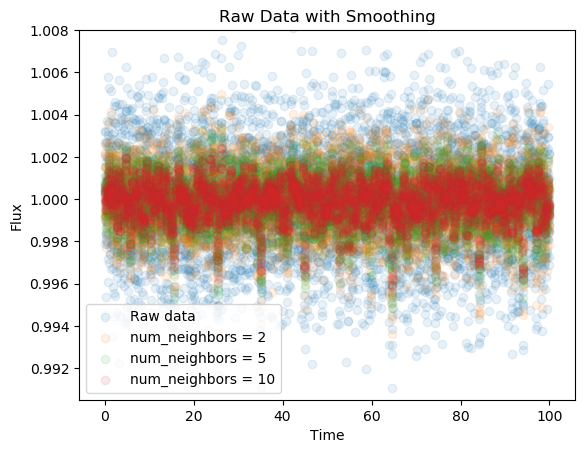

In [20]:
scatter(time, flux, alpha=0.1, label="Raw data")
scatter(time, smooth(flux, num_neighbors=2), alpha=0.1, label="num_neighbors = 2")
scatter(time, smooth(flux, num_neighbors=5), alpha=0.1, label="num_neighbors = 5")
scatter(time, smooth(flux, num_neighbors=10), alpha=0.1, label="num_neighbors = 10")
ylim([0.9905, 1.008])
title("Raw Data with Smoothing")
xlabel("Time")
ylabel("Flux")
legend()
show()

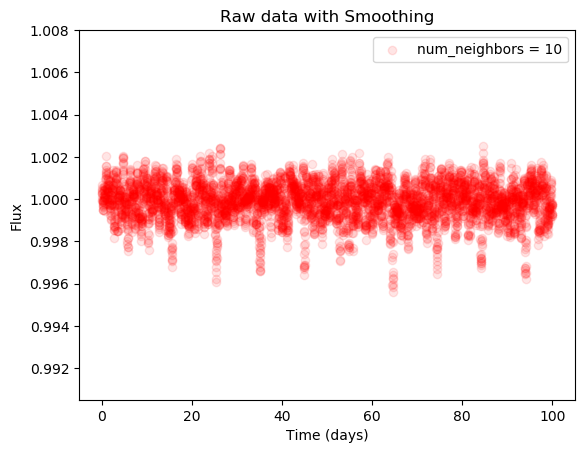

In [21]:
scatter(time, smooth(flux, num_neighbors=10), alpha=0.1, color="red", label="num_neighbors = 10")
ylim([0.9905, 1.008])
title("Raw data with Smoothing")
xlabel("Time (days)")
ylabel("Flux")
legend()
show()

We compute a periodogram using the "scatter" metric over a large range of periods between $1$ and $50$. We zoom in around the first minimum in scatter.

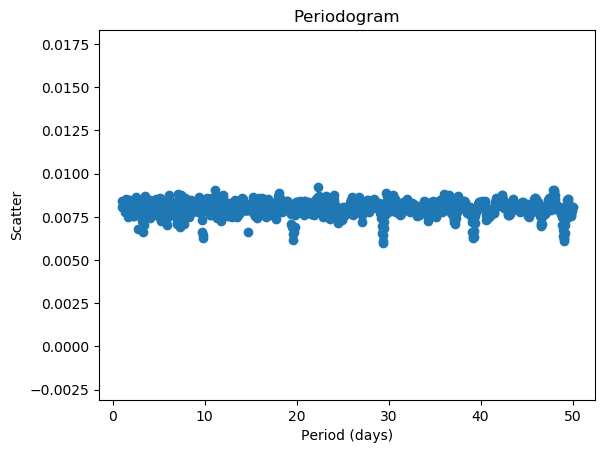

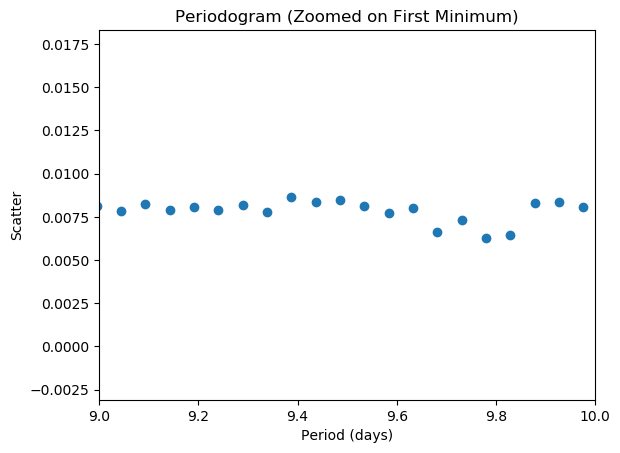

In [22]:
Ps = collect(range(1, stop=50, length=1000))
scatters = periodogram(smooth(flux, num_neighbors=10), time, Ps)
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
show()
figure()
scatter(Ps, scatters)
title("Periodogram (Zoomed on First Minimum)")
xlabel("Period (days)")
ylabel("Scatter")
xlim([9, 10])
show()

We perform a fine grid search over periods around the minimum found above to find the best period of the transit.

Best Period = 9.809609609609609 (days)


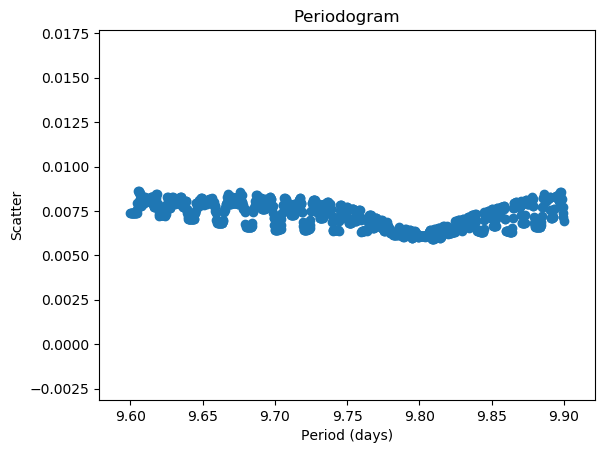

In [23]:
Ps = collect(range(9.6, stop=9.9, length=1000))
scatters = periodogram(smooth(flux, num_neighbors=10), time, Ps)
figure()
scatter(Ps, scatters)
title("Periodogram")
xlabel("Period (days)")
ylabel("Scatter")
show()
P_best = Ps[argmin(scatters)]
print("Best Period = ", P_best, " (days)\n")
flush(stdout)

We plot the smoothed data folded on the best period below, along with the raw data folded on the best period to see the transit. For both, we zoom in on the transit to make clear what the transit looks like.

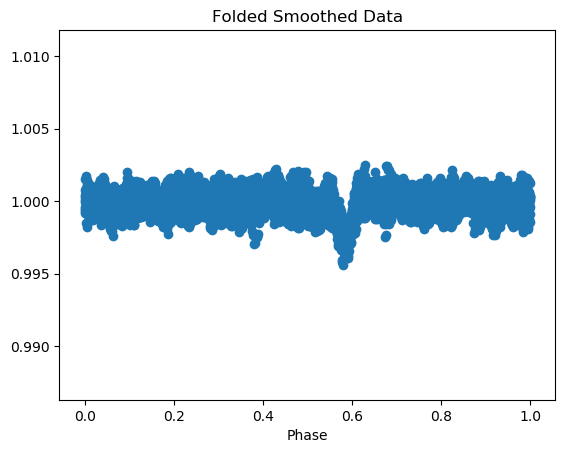

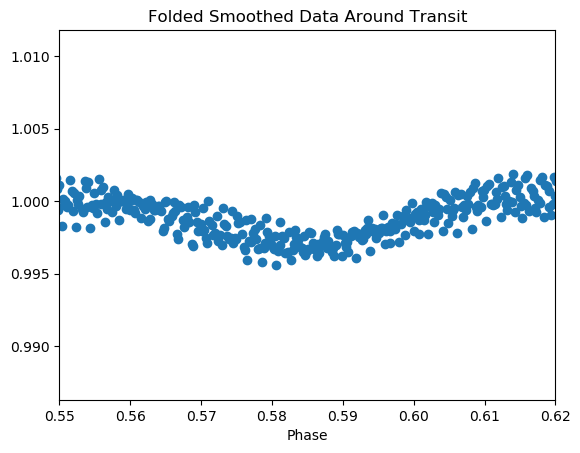

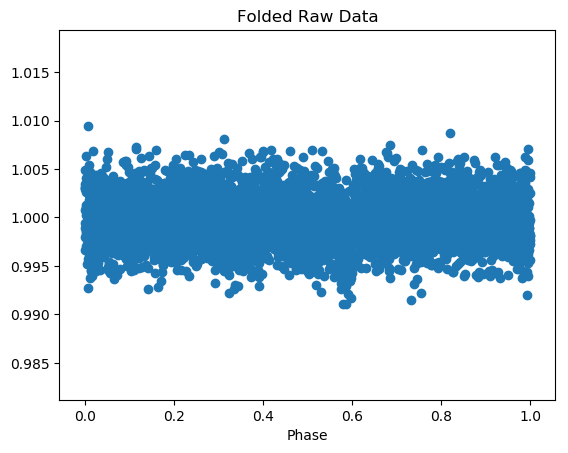

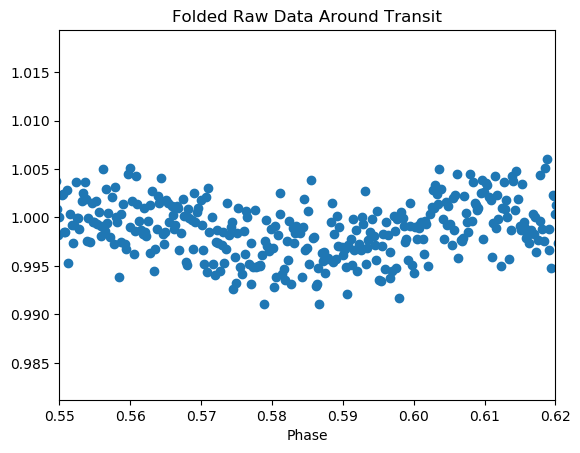

In [24]:
plot_folded_data(time, smooth(flux, num_neighbors=10), P_best)
title("Folded Smoothed Data")
show()

plot_folded_data(time, smooth(flux, num_neighbors=10), P_best)
title("Folded Smoothed Data Around Transit")
xlim([0.55, 0.62])
show()

plot_folded_data(time, flux, P_best)
title("Folded Raw Data")
show()

plot_folded_data(time, flux, P_best)
title("Folded Raw Data Around Transit")
xlim([0.55, 0.62])
show()

# Model the light curve

The separation between the centers of the planet and the star projected along the stellar equator assuming a circular (e = 0) orbit is:

$$
d_{proj}(t; P, t_p, a) = a \cos\left( M(t; P, t_p) \right)
$$

where the mean anomoly is

$$
M(t; P, t_p) = \frac{2\pi}{P} \left( t - t_p \right)
$$

so

$$
d_{proj}(t; P, t_p, a) = a \cos\left( \frac{2\pi}{P} \left( t - t_p \right) \right)
$$

Given an impact parameter $b$ of the orbit, the true distance between the centers of the planet and the star is:

$$
d(t; P, t_p, a, b) = \sqrt{d_{proj}(t; P, t_p, a)^2 + b^2}
$$

Given $d$ and the ratio of the planet and star radii $R_p /R_{*}$, we can compute the fraction of stellar flux of $\delta$ blocked by the transiting planet using the `compute_delta(d, r_p)` function. The flux we see is then $I = I_0*(1 - \delta)$:

$$
I_{model}(t; P, t_p, a, b, R_p / R_{*}) = I_0 \left( 1 - \texttt{compute_delta}\left(d(t; P, t_p, a, b), R_p / R_{*} \right) \right)
$$

Where $I_0$ is the amount of flux received from the unblocked star. $I_{model}(t; P, t_p, a, b, R_p / R_{*})$ is our model light curve. We can optimize over the unknowns $P, t_p, a, b, R_p / R_{*}$ and find that orbital parameters that minimize the chi-squared between the model light curve and the data.

#### Note that for a circular orbit, the time of periastron passage $t_p$ is not defined. However, it does have some meaning in this context, and can be described as the time that is a quarter period before the time of the midpoint of the first transit in the data.

We compute $I_0$ as the median flux level of the star, which is the total integrated unblocked flux of the star.

In [25]:
I_0 = median(flux)

0.9998877543977991

Computation of $\chi^2$ between a model and data.

In [26]:
function chi_sq(data, data_err, model)
    return sum((data .- model).^2 ./ data_err.^2)
end;

We make a function that models a lightcurve at a set of times for a given period $P$, $t_p$, $a$, $b$, $R_p / R_{*}$. We assume a constant intensity profile.

In [27]:
function model_lightcurve(times, P, t_p, a, b, radius_ratio; I_func=I_const, num_steps=100)
    if a - r_p < 1
        print("Warning! Planet interstects star: difference between semi-major axis a and planet radius r_p less than one\n") 
        flush(stdout)
        return nothing
    end
    
    M = (2 * pi / P) .* (times .- t_p)
    M_mod = M .% (2 * pi)

    # For negative M, the rules change for when in phase the planet is behind the star
    # Treat the positive and negative cases differently
    behind_star_pos = (0 .< M_mod .< pi) .& (M_mod .> 0)
    behind_star_neg = (-2 * pi .< M_mod .< -pi) .& (M_mod .< 0)
    behind_star = behind_star_pos .| behind_star_neg

    d_proj = a * cos.(M)
    d = sign.(d_proj) .* sqrt.(d_proj.^2 .+ b^2)
    flux_model = I_0 .* ( 1 .- compute_delta.(d, radius_ratio, I_func=I_func, num_steps=num_steps) )

    # Block out secondary transits
    flux_model[behind_star] .= I_0
    
    return flux_model
end;

### See how the model light curve changes with $t_p$ and $b$ for fixed $a$ and $r_p$.

We can see that $t_p$ shifts the times of transit, and $b$ changes the depth and shape of the transit.

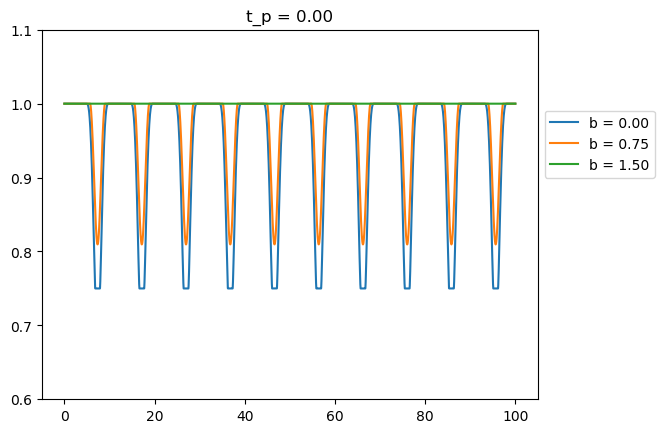

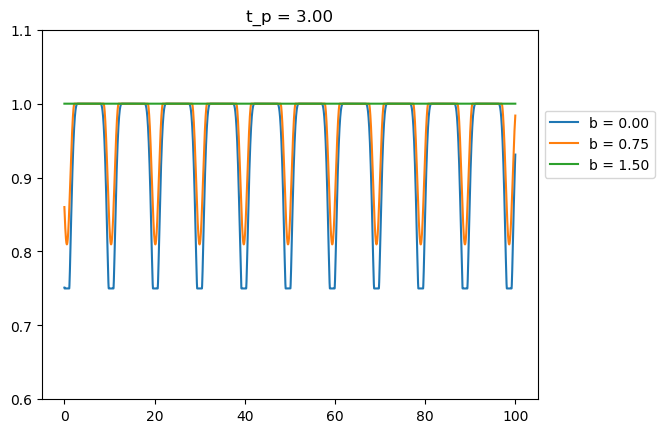

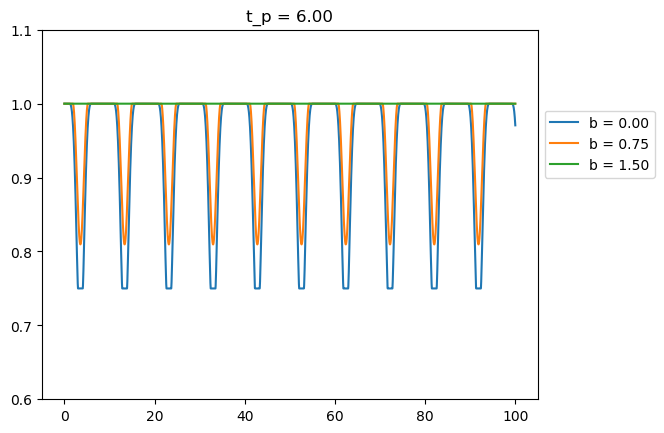

In [28]:
a = 1.5
r_p = 0.5

for t_p in range(0, stop=6, length=3)
    figure()
    for b in range(0, stop=1 + r_p, length=3)
        flux_model = model_lightcurve(time, P_best, t_p, a, b, r_p)
        plot(time, flux_model, label=@sprintf("b = %.2f", b))
    end
    ylim(0.6, 1.1)
    legend(bbox_to_anchor=(1.25, 0.8))
    title(@sprintf("t_p = %.2f", t_p))
    show()
end

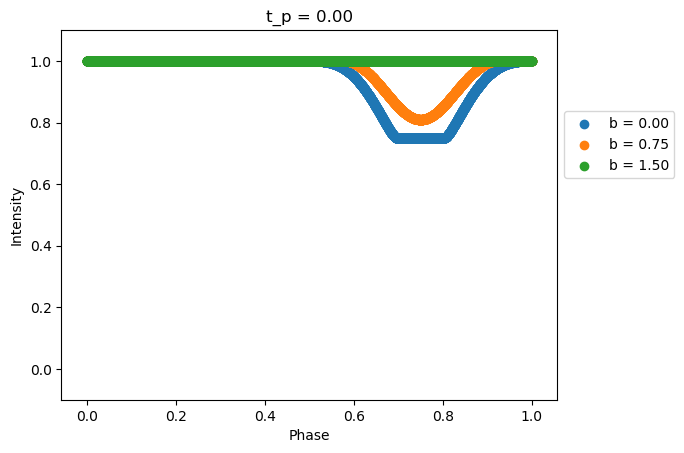

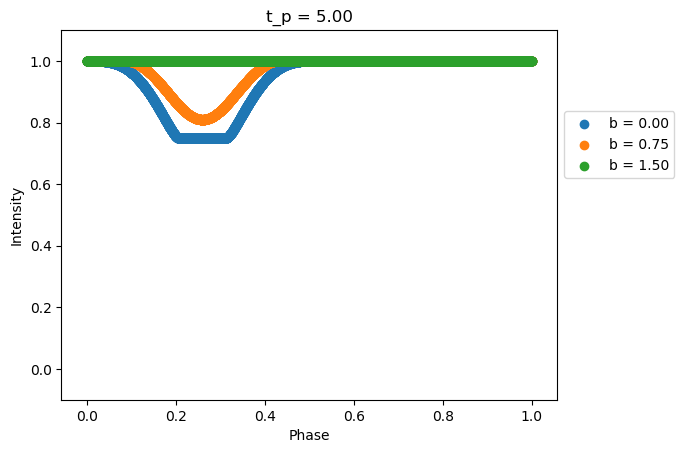

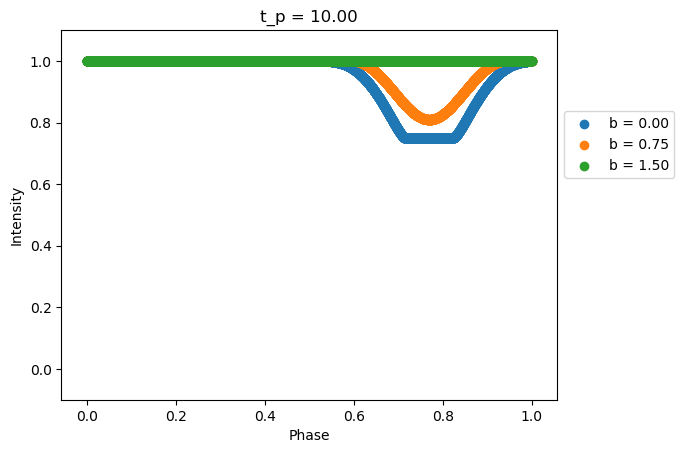

In [29]:
a = 1.5
r_p = 0.5

for t_p in range(0, stop=10, length=3)
    figure()
    for b in range(0, stop=1 + r_p, length=3)
        flux_model = model_lightcurve(time, P_best, t_p, a, b, r_p)
        
        phase = get_phase(time, P_best)
        sorted_phase_idx = sortperm(phase)

        scatter(phase[sorted_phase_idx], flux_model[sorted_phase_idx], label=@sprintf("b = %.2f", b))
    end
    ylim(-0.1, 1.1)
    legend(bbox_to_anchor=(1.25, 0.8))
    title(@sprintf("t_p = %.2f", t_p))
    xlabel("Phase")
    ylabel("Intensity")
    show()
end

### See how the model light curve changes with $a$ and $r_p$ for fixed $t_p$ and $b$.

#### Note here that we show that for $t_P = P/4$, the model predicts that $t = 0$ is the midpoint of a transit.
We see that changing $a$ and $r_p$ changes the shape of the transit.

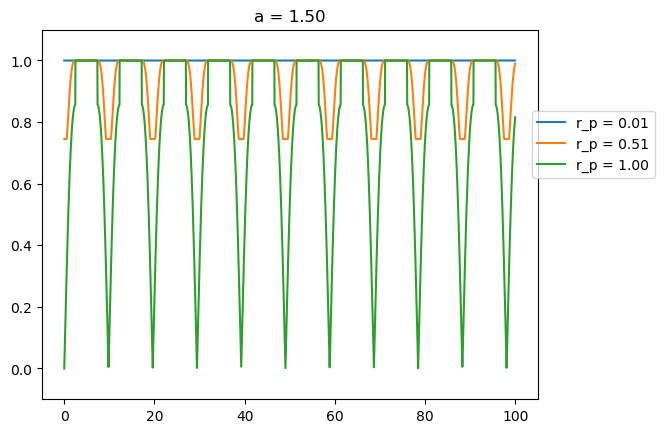

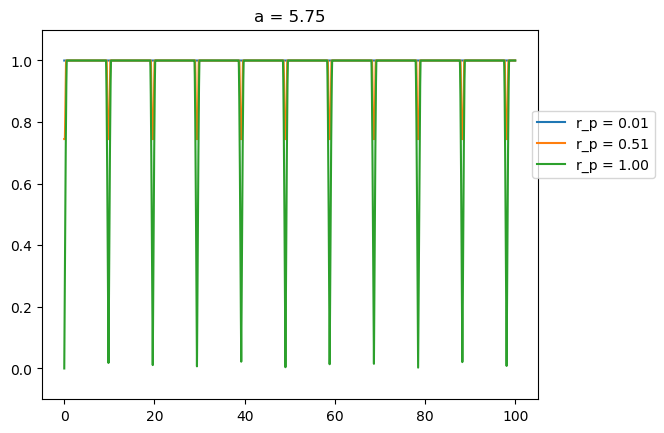

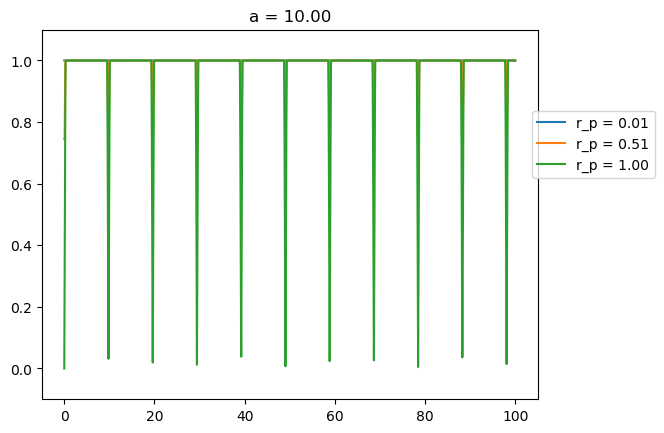

In [30]:
t_p = P_best / 4
b = 0

for a in range(1.5, stop=10, length=3)
    figure()
    for r_p in range(0.01, stop=1, length=3)
        flux_model = model_lightcurve(time, P_best, t_p, a, b, r_p)
        plot(time, flux_model, label=@sprintf("r_p = %.2f", r_p))
    end
    ylim(-0.1, 1.1)
    legend(bbox_to_anchor=(1.25, 0.8))
    title(@sprintf("a = %.2f", a))
    show()
end

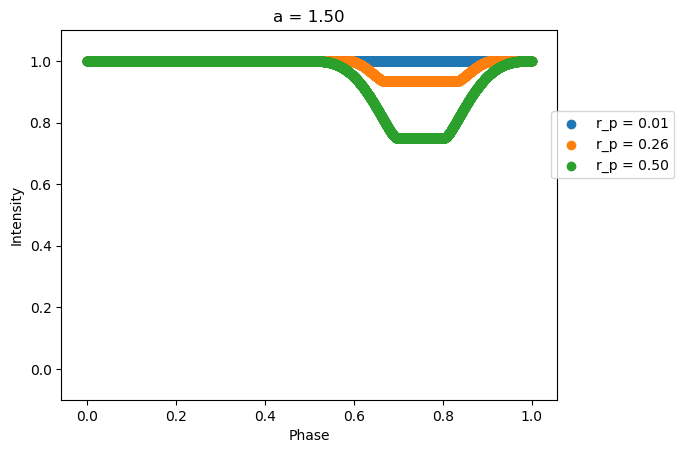

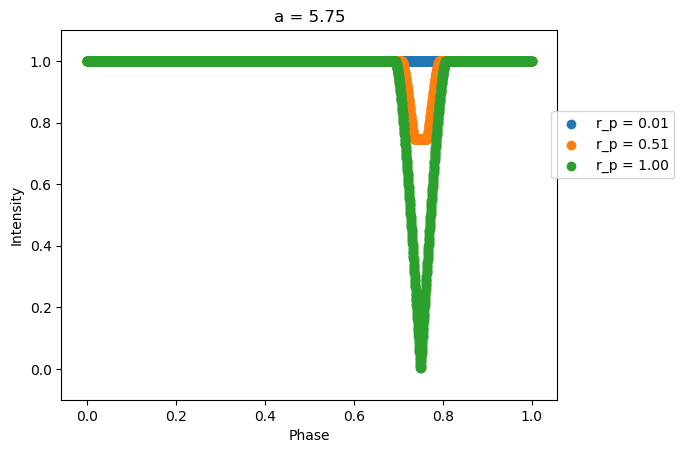

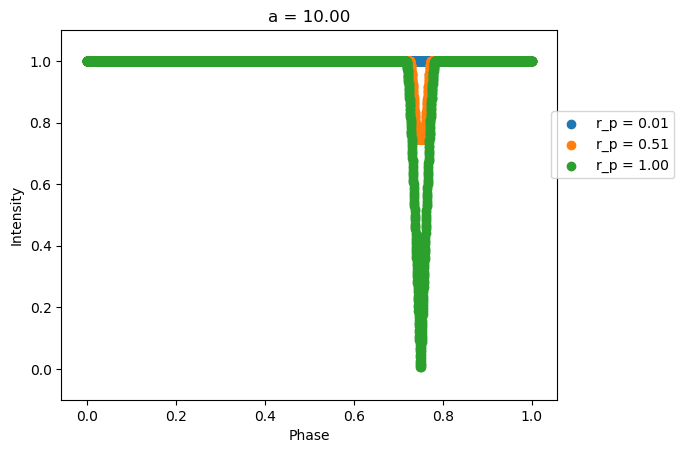

In [31]:
t_p = 0
b = 0

for a in range(1.5, stop=10, length=3)
    figure()
    for r_p in range(0.01, stop=minimum([1, a - 1]), length=3)
        flux_model = model_lightcurve(time, P_best, t_p, a, b, r_p)
        
        phase = get_phase(time, P_best)
        sorted_phase_idx = sortperm(phase)

        scatter(phase[sorted_phase_idx], flux_model[sorted_phase_idx], label=@sprintf("r_p = %.2f", r_p))
    end
    ylim(-0.1, 1.1)
    legend(bbox_to_anchor=(1.25, 0.8))
    title(@sprintf("a = %.2f", a))
    xlabel("Phase")
    ylabel("Intensity")
    show()
end

### Optimize over $r_p$, $b$, $t_p$, and $a$ to find the parameters that minimizes chi-squared between the model and the data

In [32]:
# Takes in vector of paramter values [t_p, a, b, r_p] and returns 
# chi-squared of model and data produced with those parameters
function optimize_f(x)
    t_p, a, b, r_p = x[1], x[2], x[3], x[4]
    
    # Return large chi-squared for bad choices of the parameter values
    # Bounds checking on parameters
    if (b < 0) | (b > 1) | (a < 0) | (r_p < 0) | (r_p > 1)
        return 1e20
    end
    # Planet intersects star
    if a - r_p < 1
        return 1e20 
    end
    # Model light curve and return chi-squared compared with raw data
    return chi_sq(flux, flux_err, model_lightcurve(time, P_best, t_p, a, b, r_p))
end;

In [33]:
# Plot a model on top of the data given parameters t_p, a, b, r_p
function plot_solution(t_p, a, b, r_p)
    figure()
    flux_model = model_lightcurve(time, P_best, t_p, a, b, r_p, I_func=I_const)

    phase = get_phase(time, P_best)
    sorted_phase_idx = sortperm(phase)

    flux_model = model_lightcurve(time, P_best, t_p, a, b, r_p)

    phase = get_phase(time, P_best)
    sorted_phase_idx = sortperm(phase)
    
    figure()
    scatter(phase[sorted_phase_idx], flux[sorted_phase_idx])
    scatter(phase[sorted_phase_idx], flux_model[sorted_phase_idx])
    title("Folded Transit")
    xlabel("Phase")
    show()
    figure()
    scatter(phase[sorted_phase_idx], flux[sorted_phase_idx])
    scatter(phase[sorted_phase_idx], flux_model[sorted_phase_idx])
    title("Folded Transit (Zoomed)")
    xlabel("Phase")
    xlim([0.55, 0.63])
    show()
    figure()
    scatter(time, flux)
    scatter(time, flux_model)
    xlabel("Time")
    title("All Transits")
    show()
    figure()
    scatter(time, flux)
    scatter(time, flux_model)
    xlabel("Time")
    title("Single Transit")
    xlim([0, 10])
    show()
end;

We hand-picked some values of $t_p$, $a$, $b$, and $r_p$ by changing their values and seeing what the overplotted model looks like in comparison to the data. We found values that produce a plausible transit model.

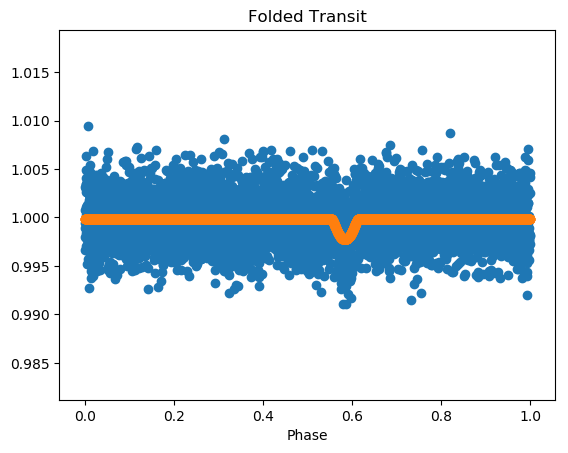

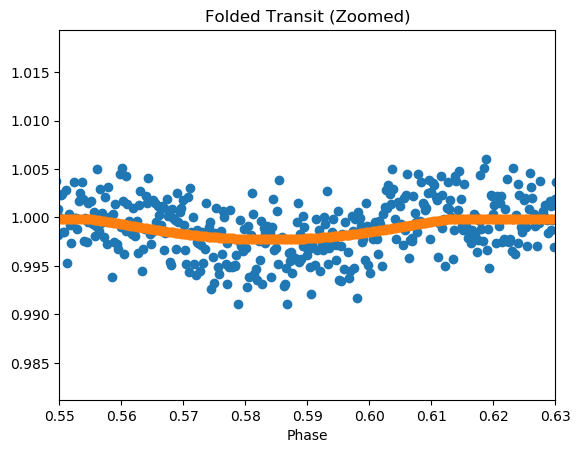

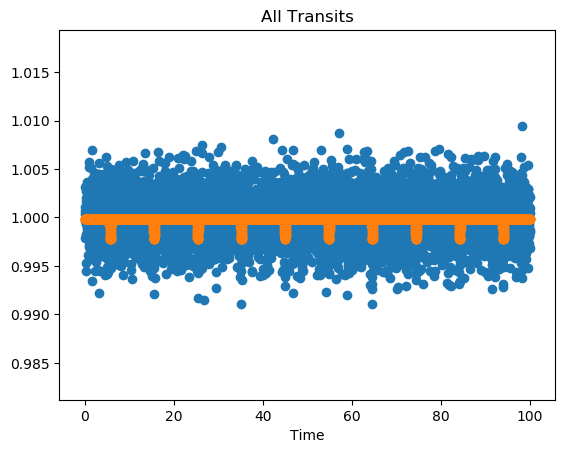

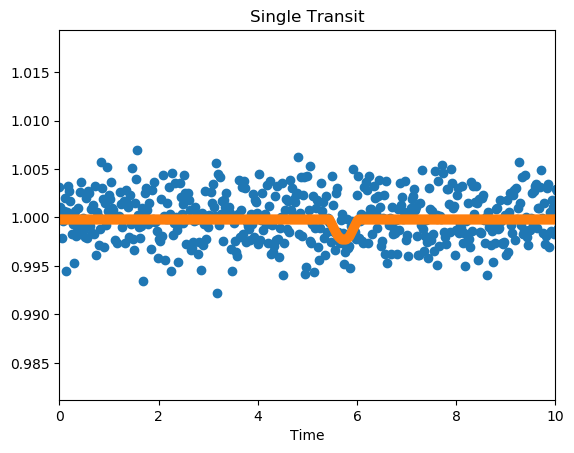

In [34]:
# Hand tweaked starting values for t_p, b, a, and r_p
t_p = 8.18
b = 0.99
a = 2
r_p = 0.06

plot_solution(t_p, a, b, r_p)

We feed these to the `Optim` package to perform a non-linear optimization over parameters with our hand-picked values as starting values.

In [35]:
# Hand tweaked starting values for t_p, b, a, and r_p
t_p = 8.18
b = 0.99
a = 2
r_p = 0.06
# Use optim to optimize over these parameters to minimze chi-squared
res = optimize(optimize_f, [t_p, a, b, r_p])
Optim.summary(res)

min_res = Optim.minimizer(res);

The transit depth can be computed by computing $\delta$ at the midpoint of the transit: $d_{proj} = 0$, $d = \sqrt{d_{proj}^2 + b^2} = b$: depth = `compute_delta(b, r_p)`. To first order, this can be approximated as $ \frac{\Delta F}{F} \approx \frac{R_p^2}{R_*^2} $

In [36]:
t_p, a, b, r_p = min_res[1], min_res[2], min_res[3], min_res[4]

depth = compute_delta(b, r_p)

print("Chi-Squared = ", optimize_f(min_res), "\n")
print("Time of periastron: ", t_p, " (days)\n")
print("Semi-major axis: ", a, " (R_star)\n")
print("Impact parameter: ", b, " (R_star)\n")
print("Radius of planet: ", r_p, " (R_star)\n")
print("Depth: ", depth, "\n")

Chi-Squared = 5119.0737492519675
Time of periastron: 8.201406772529069 (days)
Semi-major axis: 7.654991311232326 (R_star)
Impact parameter: 0.6810505278067442 (R_star)
Radius of planet: 0.05310871187408386 (R_star)
Depth: 0.002820535276924455


We plot the solution over top the data, and zoom in on the transit to compare the fit.

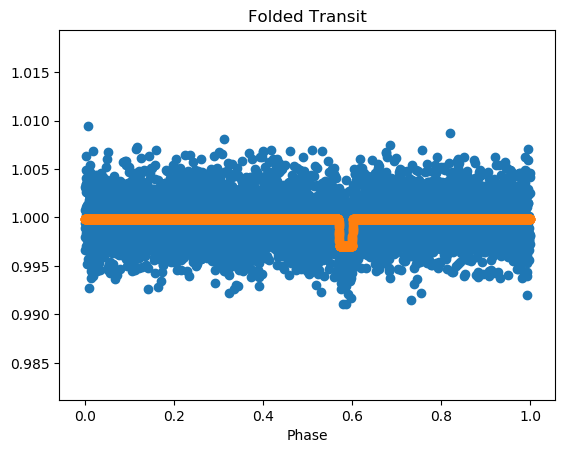

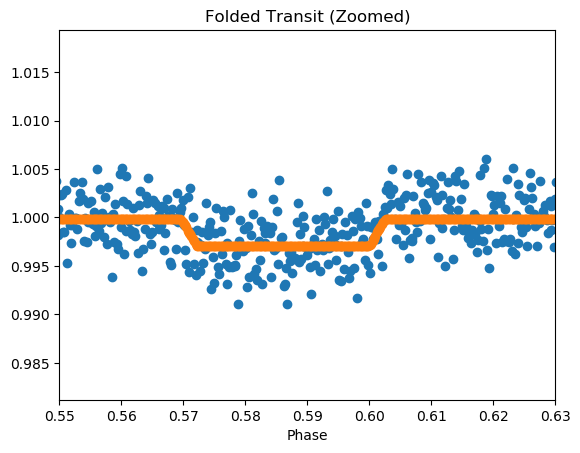

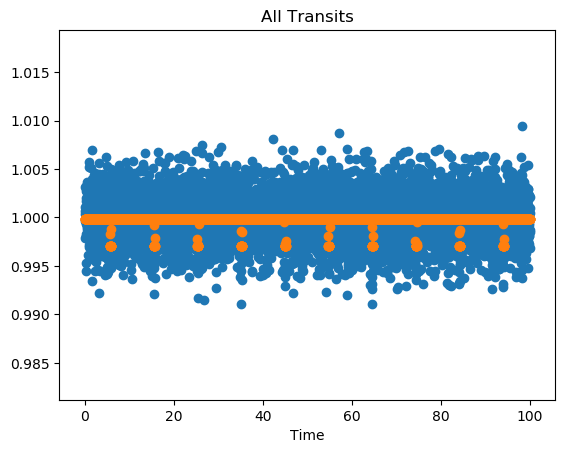

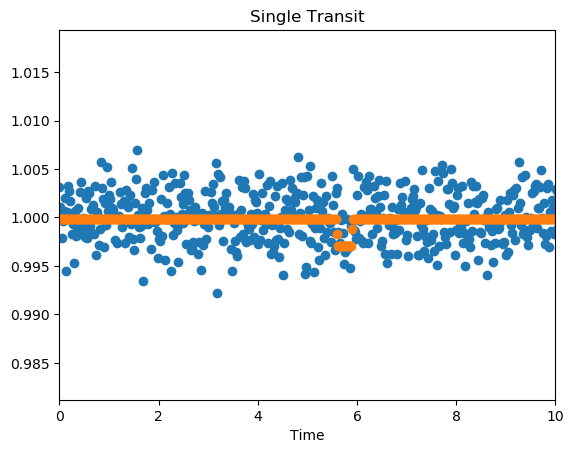

In [37]:
plot_solution(t_p, a, b, r_p)

# Compute transit duration and stellar density:

From the modeled parameters, we can compute the transit duration $T$ and the stellar density $\rho_{*}$.

Transit duration:
$$ 
T_{I, IV} = \frac{2 \sqrt{(R_{*} + R_P)^2 - (b R_{*})^2}}{v} \approx 2 \sqrt{ 1 - b^2} \frac{R_{*}}{v} ~~(R_P << R_{*})
$$

for $e = 0$

$$
T \approx \frac{\sqrt{1 - b^2} R_{*} P}{\pi a}
$$


Stellar density:
$$
T \approx ( \frac{3}{\pi^2} )^{1/3} \sqrt{1 - b^2} P^{1/3} ( G \rho_{*} )^{-1/3}
$$
$$
\rightarrow \rho_{*} = \frac{3}{\pi^2} \frac{P}{G T^3} (1 - b^2)^{3/2}
$$

In [38]:
function compute_transit_duration(a, b, P)
    R_star = 1. # stellar radii
    T = sqrt(1- b^2) * R_star * P / (pi * a)
    
    return T # days
    
end

function compute_stellar_density(P, T, b)
    G = 4.982E-10 # km^3 / kg / day^2
    
    rho_star = (3/pi^2) * P/(G*T^3) * (1-b^2)^(3/2) # kg / km^3
    
    return rho_star
end

T = compute_transit_duration(a, b, P_best)
rho_star = compute_stellar_density(P_best, T, b)
print("Transit Duration: ",T, " (days)")
print("\n")
print("Stellar Density: ",rho_star, " (kg/km^3)")

Transit Duration: 0.2986816054266497 (days)
Stellar Density: 8.818567876826839e10 (kg/km^3)

# Final Results

\begin{align*}
\chi^2       &= 5119.07 \\
t_p          &= 8.20141 ~\text{(days)} \\
a            &= 7.65499 ~(R_*) \\
b            &= 0.68105 ~(R_*) \\
r_p          &= 0.05311 ~(R_*) \\
\text{Depth} &= 0.00282 \\
T_{I,IV}     &= 0.29868 ~\text{(days)} \\
\rho         &= 8.81857\times10^{10}~(kg/km^3)
\end{align*}

![](Final_Plot.png)